# DB evaluation 

In [1]:
import pandas as pd
import json
import os
import time
import itertools
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from plotly.graph_objs import *
import os
from plotly import figure_factory as ff
import ast

In [2]:
import sys
print (sys.version)
print(pd.__version__)

3.5.2 |Anaconda 4.2.0 (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
0.19.2


## Find by coefficients best coefficients :

In [3]:
df=pd.read_csv('optimization_coefficents_tf.csv', index_col=0)

In [4]:
df = df.groupby(['Coeff 1', 'Coeff 2'])[['nbr TF', 'nbr PR']].sum()

In [5]:
df.head(100)

nbr TF  nbr PR
Coeff 1 Coeff 2                
1       1            20       0
        10           20       0
        100          20       0
10      1            25       0
        10           20       0
        100          20       0
100     1            20       0
        10           25       0
        100          20       0

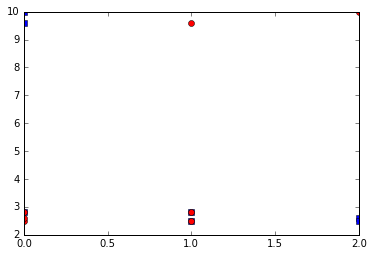

In [6]:
import matplotlib.pyplot as plt
coefficient_word = [0,1,2,0,1,2,0]
coefficient_author = [0,0,0,1,1,1,2]
score = [2.8,2.5,2.6,9.6,2.8,2.5,10]
plt.plot(coefficient_word, score, 'bs',coefficient_author,score, 'ro')
plt.show()


## Evaluation

In [3]:
df = pd.read_csv('../Data/duplicate_questions.csv') #dataFrame where questions are located

###### Compute results helpers

In [4]:
def string_to_list(mylist) :
    mylist = ast.literal_eval(mylist)
    mylist = [n.strip() for n in mylist]
    return mylist

def common_elements(list1, list2):
    return [element for element in list1 if element in list2]

def remove_duplicat(mylist):
    return list(set(mylist))

In [5]:
def find_first_match(input_dataFrame,ref_uid,recall_at):
    ''' Return the position of the first match with the uid
    If first match is greater than recall_at the number is recall_at + 1
    If the is no match return recallat + 2
    '''
    try : 
        number = input_dataFrame.uid[input_dataFrame.uid == ref_uid ].index.tolist()[0]
        if number > recall_at :
            number = recall_at + 1

    except IndexError : 
        number = recall_at + 2
    return number


def compute_recall(ref_list_uid,predicted_list,recall_at) :
    ''' Given a list of uid return the recall
    '''
    count = 0
    for e in predicted_list :
        
        if  e in ref_list_uid :
            count +=1
    
    return count/len(ref_list_uid)

###### Visualisation helper

In [15]:
# Usefull functions to perform basic statistics
def compteNumberOfMiss(l):
    count = 0
    for e in l:
        if e > recall_at :
            count +=1
    return count

def mean(l):
    mean = 0
    for e in l:
        if e > recall_at :
            pass
        else : 
            mean += e
    if len(l)-compteNumberOfMiss(l) != 0 : 
        return mean/(len(l)-compteNumberOfMiss(l))
    else :
        return -1

def SecondOrder(l):
    second = 0
    for e in l:
        if e > recall_at :
            pass
        else : 
            second += e*e
    return second/(len(l)-compteNumberOfMiss(l))


def display_graph(baseline,superuser,ubuntu,neo4j_pr,neo4j_tfidf,neo4j_pr_op,neo4j_tfidf_op, mode='RECALL'):
    plot([Scatter(x=np.arange(len(baseline)), y=baseline,mode = 'markers',name = 'SOLR '+mode),
      Scatter(x=np.arange(len(superuser)), y=superuser,mode = 'markers',name = 'RNN superuser '+ mode),
      Scatter(x=np.arange(len(ubuntu)), y=ubuntu,mode = 'markers',name = 'RNN RECALL ubuntu '+ mode),
     Scatter(x=np.arange(len(neo4j_pr)), y=neo4j_pr,mode = 'markers',name = 'NEO4J PR '+ mode),
    Scatter(x=np.arange(len(neo4j_tfidf)), y=neo4j_tfidf,mode = 'markers',name = 'NEO4J TFIDF '+ mode),
     Scatter(x=np.arange(len(neo4j_pr_op)), y=neo4j_pr_op,mode = 'markers',name = 'NEO4J PR OP '+ mode),
    Scatter(x=np.arange(len(neo4j_tfidf_op)), y=neo4j_tfidf_op,mode = 'markers',name = 'NEO4J TFIDF OP '+ mode)])

def display_statistic_table(baseline,superuser,ubuntu,neo4j_pr,neo4j_tfidf, neo4j_pr_op,neo4j_tfidf_op, mode='RECALL') :
    count = len(baseline)
    if mode == 'BEST RANKING' :
        data_matrix = [['Model', 'Mean', 'Second Order Moment','Number of miss (%)'],
                   ['Baseline '+mode, mean(baseline), SecondOrder(baseline),compteNumberOfMiss(baseline)/count],
                   ['Rnn superuser '+mode, mean(ubuntu), SecondOrder(ubuntu),compteNumberOfMiss(ubuntu)/count],
                       ['Rnn ubuntu '+mode, mean(superuser), SecondOrder(superuser),compteNumberOfMiss(superuser)/count],
                    ['Neo4j PR OP '+mode, mean(neo4j_pr), SecondOrder(neo4j_pr),compteNumberOfMiss(neo4j_pr)/(count)],
                        ['Neo4j TF_IDF '+mode, mean(neo4j_tfidf), SecondOrder(neo4j_tfidf),compteNumberOfMiss(neo4j_tfidf)/(count)],
                   ['Neo4j PR  '+mode, mean(neo4j_pr_op), SecondOrder(neo4j_pr_op),compteNumberOfMiss(neo4j_pr_op)/(count)],
                        ['Neo4j TF_IDF OP '+mode, mean(neo4j_tfidf_op), SecondOrder(neo4j_tfidf_op),compteNumberOfMiss(neo4j_tfidf_op)/(count)],
                   
                      ]
    
    
    if mode == 'RECALL' :
        data_matrix = [['Model', 'Mean'],
                   ['Baseline '+mode, mean(baseline)],
                   
                   ['Rnn ubuntu '+mode, mean(ubuntu)],
                       ['Rnn superuser '+mode, mean(superuser)],
                    ['Neo4j PR OP'+mode, mean(neo4j_pr)],
                        ['Neo4j TF_IDF '+mode, mean(neo4j_tfidf)],
                       ['Neo4j PR  '+mode, mean(neo4j_pr_op)],
                        ['Neo4j TF_IDF OP '+mode, mean(neo4j_tfidf_op)],
                   ]
        
    
    table = ff.create_table(data_matrix)
    iplot(table, filename='Model Evaluation')

###### Conpute results

In [8]:
def find_list_uid(myuid) :

    myindex = 0

    # find line :
    for index,row in df.iterrows() :
        if row['uid'] ==myuid :
            myindex = index
    
    # initialization :
    uid_duplicate_list = [myuid]+string_to_list(df.loc[myindex,'duplicate uid'])
    list_temoin = list(uid_duplicate_list)
    list_already = []
    while len(list_temoin)>0 : 
        uid = list_temoin[0]
        del list_temoin[0]
        list_already.append( uid)
        
        for index,row in df.iterrows() :
            if row['uid'] ==uid :
                uid_duplicate_list += [uid]+string_to_list(df.loc[index,'duplicate uid'])
                # update liste
                for e in remove_duplicat(uid_duplicate_list) :
                    if e not in list_already :
                        list_temoin.append(e)
                                 
            if uid in string_to_list(row['duplicate uid']) :
                uid_duplicate_list += [uid]+string_to_list(df.loc[index,'duplicate uid'])
                # update liste
                for e in remove_duplicat(uid_duplicate_list) :
                    if e not in list_already :
                        list_temoin.append(e)

    return remove_duplicat(uid_duplicate_list)

In [9]:
recall_at = 10

# Evaluation 1 : Best Ranking 
ranking_baseline = []
ranking_rnn_ubuntu = []
ranking_rnn_superuser = []
ranking_neo4j_pr = []
ranking_neo4j_tf = []
ranking_neo4j_pr_1_11 = []
ranking_neo4j_tf_1_11 = []

# Evaluation 2 : Recall
recall_baseline = []
recall_rnn_ubuntu = []
recall_rnn_superuser = []
recall_neo4j_pr = []
recall_neo4j_tf = []
recall_neo4j_pr_1_11 = []
recall_neo4j_tf_1_11 = []

In [10]:
count = 0
for filename in os.listdir(str(os.getcwd())+'/../Predictions/baseline'):
        count +=1
        uid = filename[:len(filename)-4]
    
        ## Load the results
 
        try :
            df_baseline=pd.read_csv(str(os.getcwd())+'/../Predictions/baseline/'+filename)
            df_rnn_superuser=pd.read_csv(str(os.getcwd())+'/../Predictions/RNN_superuser/'+filename)
            df_rnn_ubuntu=pd.read_csv(str(os.getcwd())+'/../Predictions/RNN_ubuntu/'+filename)
            df_neo4j_pr=pd.read_csv(str(os.getcwd())+'/../Predictions/PR/'+filename)
            df_neo4j_tfidf=pd.read_csv(str(os.getcwd())+'/../Predictions/TFIDF/'+filename)

            df_neo4j_tfidf_1_11=pd.read_csv(str(os.getcwd())+'/../Predictions/TFIDF_11_1/'+filename)
            df_neo4j_pr_1_11=pd.read_csv(str(os.getcwd())+'/../Predictions/PR_11_1/'+filename)


            uid_list =find_list_uid(uid)

            rank_first_match_baseline = []
            rank_first_match_rnn_superuser =[]
            rank_first_match_rnn_ubuntu =[]
            rank_first_match_neo4j_pr =[] 
            rank_first_match_neo4j_tfidf =[]
            rank_first_match_neo4j_pr_1_11 =[]
            rank_first_match_neo4j_tfidf_1_11 =[]

            print(count)

            #### Best Ranking mesure

            for ref_uid in uid_list  :
                # BASELINE
                rank_first_match_baseline.append(find_first_match(df_baseline,ref_uid,recall_at))

                # Neo4j_pr
                rank_first_match_neo4j_pr.append(find_first_match(df_neo4j_pr,ref_uid,recall_at))
                rank_first_match_neo4j_pr_1_11.append(find_first_match(df_neo4j_pr_1_11,ref_uid,recall_at))


                # Neo4j_tfidf
                rank_first_match_neo4j_tfidf.append(find_first_match(df_neo4j_tfidf,ref_uid,recall_at))
                rank_first_match_neo4j_tfidf_1_11.append(find_first_match(df_neo4j_tfidf_1_11,ref_uid,recall_at))

                # RNN superuser
                rank_first_match_rnn_superuser.append(find_first_match(df_rnn_superuser,ref_uid,recall_at))

                # RNN ubuntu
                rank_first_match_rnn_ubuntu.append(find_first_match(df_rnn_ubuntu,ref_uid,recall_at))

                try : 

                    # Evaluation 1 : Best Ranking 
                    best_ranking_baseline = min(rank_first_match_baseline)
                    best_ranking_rnn_superuser = min(rank_first_match_rnn_superuser)
                    best_ranking_rnn_ubuntu = min(rank_first_match_rnn_ubuntu)
                    best_ranking_neo4j_pr = min(rank_first_match_neo4j_pr)
                    best_ranking_neo4j_tf = min(rank_first_match_neo4j_tfidf)

                    best_ranking_neo4j_pr_1_11 = min(rank_first_match_neo4j_pr_1_11)
                    best_ranking_neo4j_tf_1_11 = min(rank_first_match_neo4j_tfidf_1_11)


                except ValueError :
                    # Error I cannot identify
                    print('Error')
                    best_ranking_baseline = recall_at + 3 
                    best_ranking_rnn_superuser = recall_at + 3
                    best_ranking_rnn_ubuntu =recall_at + 3
                    best_ranking_neo4j_pr = recall_at + 3
                    best_ranking_neo4j_tf = recall_at + 3

                    best_ranking_neo4j_pr_1_11 = recall_at + 3
                    best_ranking_neo4j_tf_1_11 = recall_at + 3


            ranking_baseline.append(best_ranking_baseline)
            ranking_rnn_superuser.append(best_ranking_rnn_superuser)
            ranking_rnn_ubuntu.append(best_ranking_rnn_ubuntu)
            ranking_neo4j_pr.append(best_ranking_neo4j_pr)
            ranking_neo4j_tf.append(best_ranking_neo4j_tf)

            # optimized models
            ranking_neo4j_pr_1_11.append(best_ranking_neo4j_pr_1_11)
            ranking_neo4j_tf_1_11.append(best_ranking_neo4j_tf_1_11)


            ### Recall mesure :
            recall_baseline.append(compute_recall(df_baseline['uid'].tolist()[0:9],uid_list,recall_at))
            recall_rnn_ubuntu.append(compute_recall(df_rnn_ubuntu['uid'].tolist()[0:9],uid_list,recall_at))
            recall_rnn_superuser.append(compute_recall(df_rnn_superuser['uid'].tolist()[0:9],uid_list,recall_at))
            recall_neo4j_pr.append(compute_recall(df_neo4j_pr['uid'].tolist()[0:9],uid_list,recall_at))
            recall_neo4j_tf.append(compute_recall(df_neo4j_tfidf['uid'].tolist()[0:9],uid_list,recall_at))

            recall_neo4j_pr_1_11.append(compute_recall(df_neo4j_pr_1_11['uid'].tolist()[0:9],uid_list,recall_at))
            recall_neo4j_tf_1_11.append(compute_recall(df_neo4j_tfidf_1_11['uid'].tolist()[0:9],uid_list,recall_at))
        except FileNotFoundError :
            print('coucou')

        
        

print('The number of documents is : ', count)

1
2
3
4
5
6
7
coucou
coucou
coucou
coucou
coucou
coucou
coucou
15
16
17
18
19
20
coucou
coucou
coucou
coucou
coucou
26
27
28
29
30
31
32
33
34
35
36
37
38
39
coucou
coucou
coucou
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
coucou
coucou
coucou
coucou
coucou
coucou
coucou
70
71
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
coucou
coucou
coucou
coucou
112
113
114
coucou
coucou
coucou
coucou
coucou
120
121
122
coucou
coucou
coucou
coucou
127
128
129
130
131
coucou
coucou
coucou
coucou
coucou
coucou
coucou
139
140
141
142
coucou
coucou
145
146
147
148
149
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
coucou
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
21

###### Evaluation 1 : Best ranking

In [11]:
display_graph(ranking_baseline,ranking_rnn_superuser,ranking_rnn_ubuntu,ranking_neo4j_pr,ranking_neo4j_tf,ranking_neo4j_pr_1_11,ranking_neo4j_tf_1_11 ,mode='BEST RANKING')

In [12]:
display_statistic_table(ranking_baseline,ranking_rnn_superuser,ranking_rnn_ubuntu,ranking_neo4j_pr,ranking_neo4j_tf,ranking_neo4j_pr_1_11,ranking_neo4j_tf_1_11, mode='BEST RANKING')

###### Evaluation 2 : Recall

In [13]:
display_graph(recall_baseline,recall_rnn_ubuntu,recall_rnn_superuser,recall_neo4j_pr,recall_neo4j_tf,recall_neo4j_pr_1_11,recall_neo4j_tf_1_11, mode='RECALL')

In [14]:
display_statistic_table(recall_baseline,recall_rnn_ubuntu,recall_rnn_superuser,recall_neo4j_pr,recall_neo4j_tf,recall_neo4j_pr_1_11,recall_neo4j_tf_1_11, mode='RECALL')